In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Firstly, we should install required packages

In [2]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio]  evaluate jiwer gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 126.4 MB/s eta 0:00:00


In [3]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 78.0 MB/s eta 0:00:00


#### Now we need to log in to Hugging Face and define our training arguments

In [4]:
from huggingface_hub import notebook_login
notebook_login()

# Loading and preparing dataset

#### We will use common voice audio dataset (Version 13.0) to feed into model.

In [5]:
from datasets import load_dataset,DatasetDict
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
dataset_checkpoint='mozilla-foundation/common_voice_13_0'
lang_attr,task='uz','transcribe'
dataset=load_dataset(dataset_checkpoint,lang_attr,split='train+validation')

README.md:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

DatasetNotFoundError: Dataset 'mozilla-foundation/common_voice_13_0' is a gated dataset on the Hub. You must be authenticated to access it.

In [ ]:
dataset

#### We just need audio and sentence for STT, so we will remove unnecessary features

In [ ]:
dataset=dataset.remove_columns(['client_id', 'path','up_votes', 'down_votes', 'age',
                                'gender', 'accent', 'locale', 'segment', 'variant'],)
dataset

### Preprocessing

#### Some  preprocessing methods we will apply:
* #### Undersampling (Most of the available pretrained models have been pretrained on audio datasets at a sampling rate of 16 kHz)
* #### Removing special characters (Many special characters encoded differently like: /u2019,/u0020 etc.)

In [ ]:
# ‘ ’
from datasets import Audio
dataset=dataset.cast_column('audio',Audio(sampling_rate=16000))

def cleaning_text(samples):
  text_clened=[sentence.strip() \
              .replace('’',"'") \
               .replace('‘',"'")\
               .replace('”','"')\
               .replace('“','"')\
               .replace('»','"')\
               .replace('«','"')\
               .replace('`',"'")\
               
                for sentence in samples['sentence']]
  samples['sentence']=text_clened
  return samples
    
cleaned_dataset=dataset.map(cleaning_text,batched=True)

# Tokenization and Feature Extraction


* #### Whisper Processor-> that combines both the Feature Extractor and Tokenizer.
* #### Whisper Feature Extractor-> Converts raw audio (16kHz waveform) into Mel spectrograms (80 frequency bins).
* #### Whisper Tokenizer-> Converts text into token IDs (for training) and tokens back to text (for transcription output).

In [ ]:
from transformers import WhisperFeatureExtractor,WhisperTokenizer,WhisperProcessor
language='uzbek'
task='transcribe'
model_checkpoint='openai/whisper-large-v2'
feature_extractor=WhisperFeatureExtractor.from_pretrained(model_checkpoint)
tokenizer=WhisperTokenizer.from_pretrained(model_checkpoint,language=language,task=task)
processor=WhisperProcessor.from_pretrained(model_checkpoint,language=language,task=task)

In [ ]:
import os
num_of_device=os.cpu_count()
print(num_of_device)

#### Actually We should not use entire dataset, since it takes so many time and device memory for fine-tuning.
#### Let's take just 10.000 dataset raws

In [ ]:
dataset=dataset.select(range(10000))
dataset=dataset.train_test_split(test_size=0.1,seed=23)
dataset['validation']=dataset.pop('test')
dataset

#### As mentioned above, we will extract features

In [ ]:
def prepare_features(samples):
  audio_array=samples['audio']['array']
  sentence=samples['sentence']
  sampling_rate=samples['audio']['sampling_rate']

  samples['input_features']=feature_extractor(audio_array,sampling_rate=sampling_rate,return_tensors='pt').input_features[0]
  samples['labels']=tokenizer(sentence).input_ids

  return samples

dataset_prep=dataset.map(prepare_features,remove_columns=dataset.column_names['train'],
                         num_proc=1)

#### Now, we define evaluation metric.
#### WER (Word Error Rate) is mostly used metric to calculate STT accuracy
#### How it work:
<img src="https://sonix.ai/packs/media/images/corp/articles/word-error-rate-2017-c5aba7282b39531154f5676a184c7ec4.png" width="500">
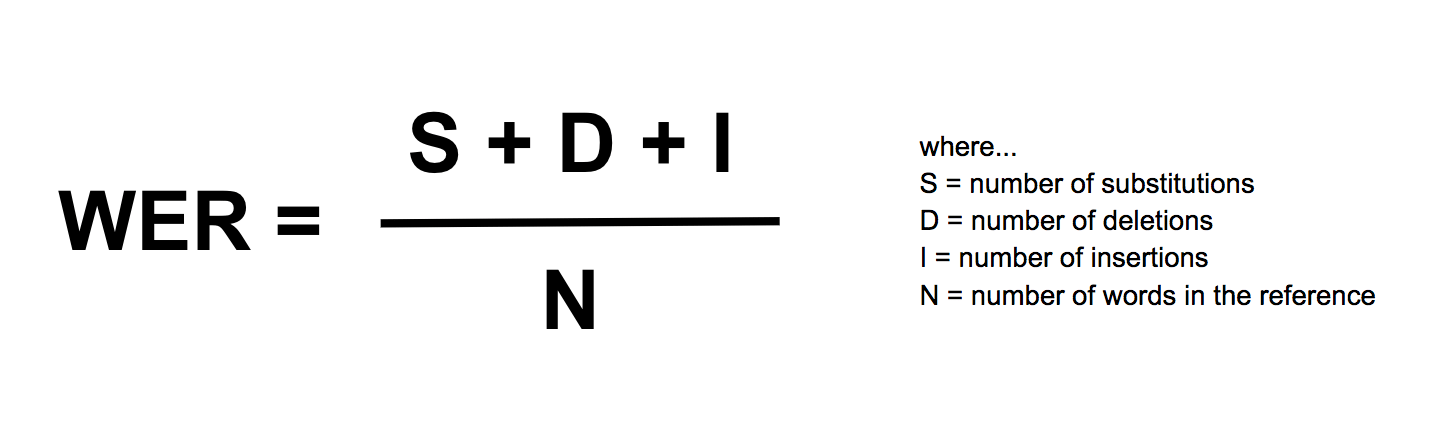

In [ ]:
import evaluate
metric=evaluate.load('wer')

#### Also we define data collator function

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

# Fine-Tuning model

#### Let's briefly talk about Whsiper
**The Whisper model, developed by OpenAI, is a speech-to-text (ASR) model that transcribes audio into text. It is a transformer-based model trained on 680,000 hours of multilingual and multitask data, making it highly robust for diverse accents, background noise, and multiple languages.**

 **According to whisper-large-v2 model, it has around 1.5 bn parameters. It  means that fine-tuning process requires so much time and computational resources. But, we can use PEFT (Parameter Efficent Fine-Tuning) approach for working large models efficently.**
##### **Most used mehod of PEFT is LORA(Low-Rank Adaption:**
<img src="https://miro.medium.com/v2/resize:fit:979/1*-uBCFiiNeOeTLvUtfdA85w.png" width="500">

In [ ]:
from transformers import WhisperForConditionalGeneration
model_checkpoint='openai/whisper-large-v2'
model = WhisperForConditionalGeneration.from_pretrained(model_checkpoint,load_in_8bit=True,device_map='auto')

#### We configure LORA

In [ ]:
from peft import prepare_model_for_kbit_training
from peft import LoraConfig,LoraModel,PeftModel,get_peft_model

model=prepare_model_for_kbit_training(model)

def make_inputs_require_grad(module, input, output):
    output.requires_grad_(True)

model.model.encoder.conv1.register_forward_hook(make_inputs_require_grad)

config=LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=['q_proj','v_proj'],
    lora_dropout=0.05,
    bias='none',
)
model=get_peft_model(model,config)
model.print_trainable_parameters()

#### We are ONLY using 1% of the total trainable parameters, thereby performing Parameter-Efficient Fine-Tuning

#### Then we define training arguments argument

In [ ]:
from transformers import Seq2SeqTrainingArguments


training_args = Seq2SeqTrainingArguments(
    output_dir="ShakhzoDavronov/whisper-large-lora-uz",
    report_to='none',
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-3,
    warmup_steps=50,
    num_train_epochs=1,
    evaluation_strategy="steps",
    fp16=True,
    per_device_eval_batch_size=4,
    generation_max_length=128,
    logging_steps=300,
#    max_steps=100, # only for testing purposes, remove this from your final run :)
    remove_unused_columns=False,  # required as the PeftModel forward doesn't have the signature of the wrapped model's forward
    label_names=["labels"],  # same reason as above
)
import torch
torch.cuda.empty_cache()  

In [ ]:
from transformers import Seq2SeqTrainer, TrainerCallback, TrainingArguments, TrainerState, TrainerControl
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR

# This callback helps to save only the adapter weights and remove the base model weights.
class SavePeftModelCallback(TrainerCallback):
    def on_save(
        self,
        args: TrainingArguments,
        state: TrainerState,
        control: TrainerControl,
        **kwargs,
    ):
        checkpoint_folder = os.path.join(args.output_dir, f"{PREFIX_CHECKPOINT_DIR}-{state.global_step}")

        peft_model_path = os.path.join(checkpoint_folder, "adapter_model")
        kwargs["model"].save_pretrained(peft_model_path)

        pytorch_model_path = os.path.join(checkpoint_folder, "pytorch_model.bin")
        if os.path.exists(pytorch_model_path):
            os.remove(pytorch_model_path)
        return control


trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset_prep["train"],
    eval_dataset=dataset_prep["validation"],
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
    callbacks=[SavePeftModelCallback],
)
model.config.use_cache=False

In [ ]:
import torch
torch.cuda.empty_cache()

#### Finally, we will begin fine-tuning process

In [ ]:
trainer.train()

#### Pushing fine-tuned model to huggingface

In [ ]:
peft_model_id = "ShakhzoDavronov/whisper-large-lora-uz"
model.push_to_hub(peft_model_id)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import WhisperForConditionalGeneration, Seq2SeqTrainer

#peft_model_id = "ShakhzoDavronov/whisper-stt-lora-uz" # Use the same model ID as before.
peft_config = PeftConfig.from_pretrained(peft_model_id)
model = WhisperForConditionalGeneration.from_pretrained(
    peft_config.base_model_name_or_path, load_in_8bit=True, device_map="auto"
)
model = PeftModel.from_pretrained(model, peft_model_id)
model.config.use_cache = True

#### Let's calculate WER with validation data

In [ ]:
import gc
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

eval_dataloader = DataLoader(dataset_prep["validation"], batch_size=8, collate_fn=data_collator)
forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task=task)
normalizer = BasicTextNormalizer()

predictions = []
references = []
normalized_predictions = []
normalized_references = []

model.eval()
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            generated_tokens = (
                model.generate(
                    input_features=batch["input_features"].to("cuda"),
                    forced_decoder_ids=forced_decoder_ids,
                    max_new_tokens=255,
                )
                .cpu()
                .numpy()
            )
            labels = batch["labels"].cpu().numpy()
            labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)
            decoded_preds = processor.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
            predictions.extend(decoded_preds)
            references.extend(decoded_labels)
            normalized_predictions.extend([normalizer(pred).strip() for pred in decoded_preds])
            normalized_references.extend([normalizer(label).strip() for label in decoded_labels])
        del generated_tokens, labels, batch
    gc.collect()
wer = 100 * metric.compute(predictions=predictions, references=references)
normalized_wer = 100 * metric.compute(predictions=normalized_predictions, references=normalized_references)
eval_metrics = {"eval/wer": wer, "eval/normalized_wer": normalized_wer}

print(f"{wer=} and {normalized_wer=}")
print(eval_metrics)

#### There is two evalutaion values: WER and normalized WER
#### Normalized WER is a variant of WER that applies text normalization before computing the error rate.